# Libraries & Data Importation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install einops
!pip install transformers
!pip install vit-pytorch linformer

!pip install wandb

In [ ]:
# import wandb
# from wandb.keras import WandbCallback

# wandb.login()

[resource](https://github.com/pytorch/vision/blob/6b071be9da221998c9ba4173fb5e4186dabdc9fe/torchvision/datasets/folder.py#L65) , [optimizers](https://pytorch.org/docs/stable/optim.html), [HuggiFace](https://huggingface.co/transformers/model_doc/vit.html), [Guide](https://colab.research.google.com/drive/1Y_RkKMr-pxGfoYbqUoYlE6HW3WHZDOFx), [Fine-tuning](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb#scrollTo=HimhtFgIxEfg).

In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

import einops
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary


import torch.nn as nn
import torch.nn.functional as F

# loading Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1000)

# import Linformer
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

# import torch and related libraries
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR, ExponentialLR  
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms 
from torchvision.transforms import ToTensor


#sklearn to split the data

from sklearn.model_selection import train_test_split

## model 1

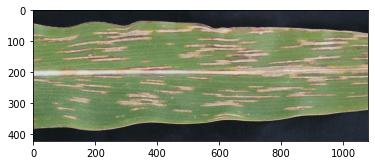

In [ ]:
# Prreview sample image

img = Image.open('/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train/Blight/Corn_Blight (101).jpg')

fig = plt.figure()
plt.imshow(img)

In [ ]:
#  preprocess the image
# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape


torch.Size([1, 3, 224, 224])

In [ ]:
#break-down the image in multiple patches and flatten them.
#This can be easily done using einops.

patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.proj = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
           # '''using a Conv2d layer instead of a Linear one for performance gain.
           #  This is obtained by using a kernel_size and stride equal to the patch_size.'''

            # Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            # nn.Linear(patch_size * patch_size * in_channels, emb_size)
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.proj(x)
        #add the cls token and the position embedding.
         #"""The cls token is just a number placed in from of each sequence (of projected patches)"""
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

#cls_token is a torch Parameter randomly initialized, in the forward the method it is copied b (batch) times 
#and prepended before the projected patches using torch.cat

torch.Size([1, 197, 768])

## Position Embedding

* So far, the model has no idea about the original position of the patches.
* We need to pass this spatial information. 
* This can be done in different ways, in ViT we let the model learn it. 
* The position embedding is just a tensor of shape N_PATCHES + 1 (token), EMBED_SIZE that is added to the projected patches.

In [ ]:
# class PatchEmbedding(nn.Module):
#     def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
#         self.patch_size = patch_size
#         super().__init__()
#         self.projection = nn.Sequential(
#             # using a conv layer instead of a linear one -> performance gains
#             nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
#             Rearrange('b e (h) (w) -> b (h w) e'),
#         )
#         self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
#         self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
#     def forward(self, x: Tensor) -> Tensor:
#         b, _, _, _ = x.shape
#         x = self.projection(x)
#         cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
#         # prepend the cls token to the input
#         x = torch.cat([cls_tokens, x], dim=1)
#         # add position embedding
#         x += self.positions
#         return x
    
# PatchEmbedding()(x).shape

# #We added the position embedding in the .positions field and sum it to the patches in the .forward function

torch.Size([1, 197, 768])

In [ ]:
# To implement Transformer in ViT only the Encoder is used

# DEiT Transformers

# Hugging Face
      * google/vit-base-patch16-224-in21k

In [ ]:
#nstall the HuggingFace's transformers repository.
%%capture

!pip install -q git+https://github.com/huggingface/transformers

from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput

In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np


# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Streamlit

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/MOG/model.pt'
model1 = torch.load(MODEL_PATH,map_location=torch.device('cpu'))
#model1.eval()


In [ ]:
#  with col2:
#                 #Model path
#                 MODEL_PATH = "C:\Users\QUINCY\Downloads\ViT_model.pt"
#                 #load model
#                 model = torch.load(MODEL_PATH)

#                 #Image Folder Path
#                 image_path = "C:\Users\QUINCY\Desktop\maizeimage\Images\"                
#                 img = path+uploaded_file

#                 #Image preprocess
#                 data_transforms = transforms.Compose(
#                     [
#                      transforms.Resize((224, 224)),
#                      transforms.ToTensor(),
#                      ])

#                train_ds = torchvision.datasets.ImageFolder(path, transform=data_transforms)
#                test_loader  = data.DataLoader(train_ds)
               
#                #Predict
#                with torch.no_grad():
#                  inputs, target = next(iter(test_loader))
#                  inputs = inputs[0].permute(1, 2, 0)
#                  for index, array in enumerate(inputs):
#                    inputs[index] = np.squeeze(array)
#                 inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))


#                 inputs = inputs.to(device)
#                 target = target.to(device)

#                #output = model1(inputs,target)
#                prediction, loss = model1(inputs, target)
    
#               # Predicted class value using argmax
#                predicted_class = np.argmax(prediction.cpu())
#                value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
#                value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
#                 #print(value_predicted)
                


                
                
#                 #model.eval()\\

In [ ]:
# uploaded_file = st.file_uploader("Upload An Image",type=['png','jpeg','jpg'])
# ifuploaded_file is not None:
#     file_details = {"FileName"uploaded_file.name,"FileType"uploadede_file.type}
#     # st.write(file_details)
#     # img = load_imageuploadede_file)
#     #st.image(img,height=250,width=250)
#     with open(os.path.join("tempDir"uploadede_file.name),"wb") as f: 
#       f.writeuploaded_file.getbuffer())         
#     st.success("Saved File")

In [ ]:
# ##uploaded_file= '/content/data/images/Corn_Blight (14).jpg'
# path = '/content/data'
# img =uploaded_file
# #images = '/content/data/images'
# #Image preprocess
# data_transforms = transforms.Compose(
#                     [
#                      transforms.Resize((224, 224)),
#                      transforms.ToTensor(),
#                      ])

# train_ds = torchvision.datasets.ImageFolder(path, transform=data_transforms)
# # img = Image.open(uploaded_file) 
# # img = data_transforms(img)
# test_loader  = data.DataLoader(train_ds) 


In [ ]:

# with torch.no_grad():
#   inputs, target = next(iter(test_loader))
#   inputs = inputs[0].permute(1, 2, 0)
#   for index, array in enumerate(inputs):
#       inputs[index] = np.squeeze(array)
#   inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))


#   inputs = inputs.to(device)
#   target = target.to(device)

#   #output = model1(inputs,target)
#   prediction, loss = model1(inputs, target)
    
#   # Predicted class value using argmax
#   predicted_class = np.argmax(prediction.cpu())
#   value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
#   value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
# print(value_predicted)

Common_rust


In [ ]:
# inputs, target = next(iter(test_loader))
# inputs = inputs[0].permute(1, 2, 0)
# for index, array in enumerate(inputs):
#     inputs[index] = np.squeeze(array)
# inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))


# inputs = inputs.to(device)
# target = target.to(device)


In [ ]:
# trans = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
#     ])
# image = Image.open(uploaded_file)
# input = trans(image)

In [ ]:
value_predicted

'Blight'

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#model1.to(device)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# EVAL_BATCH = 1
# #eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=2) 
# test_loader  = data.DataLoader(img, batch_size=1, shuffle=True, num_workers=0) 
# # Disable grad
# with torch.no_grad():
#   #for inputs, target in   
#   inputs, target = next(iter(test_loader))
#   # Reshape and get feature matrices as needed     #### valid_ds
#   print(inputs.shape)
#   #permute() rearranges the original tensor according to the desired ordering and returns a new multidimensional rotated tensor.
#   inputs = test_loader[0].permute(1, 2, 0)    
#   #inputs = inputs.permute(1, 2, 0)
#   # Save original Input
#   originalInput = inputs
#   for index, array in enumerate(inputs):
#     inputs[index] = np.squeeze(array)
#   inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

#   # Send to appropriate computing device
#   inputs = inputs.to(device)
#   target = target.to(device)
 
#   # Generate prediction
#   prediction, loss = model(inputs, target)
    
#   # Predicted class value using argmax
#   predicted_class = np.argmax(prediction.cpu())
#   value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
#   value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
  
  
#     # Show result
#   plt.imshow(originalInput)
#   plt.xlim(224,0)
#   plt.ylim(224,0)
#   plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
#   plt.show()

#The Model

## Loading the data

In [ ]:
#Get the data path
train_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
test_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'
valid_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'


#convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure
import torchvision
from torchvision import transforms 
from torchvision.transforms import ToTensor

data_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

train_ds = torchvision.datasets.ImageFolder(train_dir, transform=data_transforms)
test_ds = torchvision.datasets.ImageFolder(valid_dir, transform=data_transforms)
valid_ds = torchvision.datasets.ImageFolder(test_dir, transform=data_transforms)

## Define the Model


* The model uses a linear layer on top of a pre-trained `ViTModel`. 
* We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. 
* We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.

In [ ]:
# #Defining the model

# class ViTForImageClassification(nn.Module):
#     def __init__(self, num_labels=6):
#         super(ViTForImageClassification, self).__init__()
#         self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
#         self.dropout = nn.Dropout(0.1)
#         self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
#         self.num_labels = num_labels

#     def forward(self, pixel_values, labels):
#         outputs = self.vit(pixel_values=pixel_values)
#         output = self.dropout(outputs.last_hidden_state[:,0])
#         logits = self.classifier(output)

#         loss = None
#         if labels is not None:
#           loss_fct = nn.CrossEntropyLoss()
#           loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#           #loss = loss_fct
#         if loss is not None:
#           return logits, loss.item()
#         else:
#           return logits, None

In [ ]:
# class ViTForImageClassification(nn.Module):
#   def __init__(self, *, image_size, patch_size, num_classes, dim, transformer, pool = 'cls', channels = 3):
#         super().__init__()
#         assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
#         assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
#         num_patches = (image_size // patch_size) ** 2
#         patch_dim = channels * patch_size ** 2

#         self.to_patch_embedding = nn.Sequential(
#             Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
#             nn.Linear(patch_dim, dim),
#         )

#         self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
#         self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
#         self.transformer = transformer

#         self.pool = pool
#         self.to_latent = nn.Identity()

#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(dim),
#             nn.Linear(dim, num_classes)
#         )

#   def forward(self, img):
#         x = self.to_patch_embedding(img)
#         b, n, _ = x.shape

#         cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
#         x = torch.cat((cls_tokens, x), dim=1)
#         x += self.pos_embedding[:, :(n + 1)]
#         x = self.transformer(x)

#         x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

#         x = self.to_latent(x)
#         return self.mlp_head(x)


In [ ]:
# img_P = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test/Common_rust/Corn_Common_Rust (36)3022.jpg'
# labels = [path.split('/')[-2].split('.jpg') for path in img_P]

In [ ]:
#Defining the model

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=6):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        return logits

NameError: ignored

In [ ]:
# def loss_fct(labels):
#   if label is not None:
#     loss_fct = nn.CrossEntropyLoss()
#     loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#     if loss is not None:
#       return loss.item()
      

In [ ]:
#Define the Model Parameters
#We train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5

EPOCHS = 5
BATCH_SIZE = 20
LEARNING_RATE = 2e-5


### Model Specifics
        * We will use the pretrained Vision Transformer feature extractor
        * an Adam Optimizer,
        * Cross Entropy Loss function.

In [ ]:
# dirpath = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
# #imagespath = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test/Common_rust'
# labeld = []
# for filename in sorted(os.listdir(dirpath)):
#   #for filename in sorted(os.listdir(imagespath)):
#   if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".JPEG") or filename.endswith(".JPG"):
#      label = imagespath.split('/')[-1]
#      labeld.append(label)


In [ ]:
# myset = set(labeld)
# print(myset)
# print(len(labeld))

* A PyTorch Tensor is basically the same as a numpy array. It's just a generic n-dimensional array to be used for arbitrary numeric computation.

* CUDA is a parallel computing platform and programming model developed by Nvidia that focuses on general computing on GPUs. CUDA speeds up various computations helping developers unlock the GPUs full potential.

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

True

In [ ]:
config = dict(
    epochs=5,
    batch_size=20,
    learning_rate= 0.00002,
    dataset="Maize Images",
    architecture="VIT")

BATCH_SIZE = 20
LEARNING_RATE = 2e-5

In [ ]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch



#model = ... # set up your model
with wandb.init(project="ViT", config=config  ):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # Define Model
      model = ViTForImageClassification(len(train_ds.classes))    
      # Feature Extractor
      feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
      # Adam Optimizer
      optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
      # Cross Entropy Lossconfig.loss_function #
      loss_func = nn.CrossEntropyLoss()
      # Use GPU if available  
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
      if torch.cuda.is_available():
          model.cuda()

      # Magic
      wandb.watch(model, log_freq=100)

NameError: ignored

### Model Training

In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)  # (Change to two)

#The num_workers attribute tells the data loader instance how many sub-processes to use for data loading.
#By default, the num_workers value is set to zero, and a value of zero tells the loader to load the data inside the main process.

NameError: ignored

In [ ]:
# Train the model
with wandb.init(project="ViT", config=config  ):
  for epoch in range(EPOCHS):        
   for step, (x, y) in enumerate(train_loader):
 
      # Change input array into list with each batch being one element
      x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
      # Remove unecessary dimension
      for index, array in enumerate(x):
        x[index] = np.squeeze(array)
     # Apply feature extractor, stack back into 1 tensor and then convert to tensor
      x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
      # Send to GPU if available
      x, y  = x.to(device), y.to(device)
      b_x = Variable(x)   # batch x (image)
      b_y = Variable(y)   # batch y (target)
     # Feed through model
     # loss = loss_fct(logits.view(-1, self.num_y), y.view(-1)) 
      output = model(b_x)
     # Calculate loss
     #loss = loss_fct(logits.view(-1, self.num_y), y.view(-1)) 
      #if loss is None:
      
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

      if step % 50 == 0:
      # Get the next batch for testing purposes
        test = next(iter(test_loader))
        test_x = test[0]
      # Reshape and get feature matrices as needed
        test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)   #check split for un even sample
        for index, array in enumerate(test_x):
          test_x[index] = np.squeeze(array)
        test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
        test_x = test_x.to(device)
        test_y = test[1].to(device)
       # Get output (+ respective class) and compare to target          ****1h 11m 14s completed at 10:34 AM****
        test_output = model(test_x)
        loss = loss_func(test_output, test_y)
        test_output = test_output.argmax(1)
      
      # Calculate Accuracy
        accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
        wandb.log({"loss": loss,
                 "val_acc":accuracy })
        print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

NameError: ignored

In [ ]:
# ### ORIGINAL

# # Train the model
# for epoch in range(EPOCHS):        
#   for step, (x, y) in enumerate(train_loader):
#     # Change input array into list with each batch being one element
#     x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
#     # Remove unecessary dimension
#     for index, array in enumerate(x):
#       x[index] = np.squeeze(array)
#     # Apply feature extractor, stack back into 1 tensor and then convert to tensor
#     x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
#     # Send to GPU if available
#     x, y  = x.to(device), y.to(device)
#     b_x = Variable(x)   # batch x (image)
#     b_y = Variable(y)   # batch y (target)
#     # Feed through model
#     output, loss = model(b_x, None)
#     # Calculate loss
#     if loss is None: 
#       loss = loss_func(output, b_y)   
#       optimizer.zero_grad()           
#       loss.backward()                 
#       optimizer.step()

#     if step % 50 == 0:
#       # Get the next batch for testing purposes
#       test = next(iter(test_loader))
#       test_x = test[0]
#       # Reshape and get feature matrices as needed
#       test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)   #check split for un even sample
#       for index, array in enumerate(test_x):
#         test_x[index] = np.squeeze(array)
#       test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
#       # Send to appropirate computing device
#       test_x = test_x.to(device)
#       test_y = test[1].to(device)
#       # Get output (+ respective class) and compare to target
#       test_output, loss = model(test_x, test_y)
#       test_output = test_output.argmax(1)
#       # Calculate Accuracy
#       accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
#       print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path

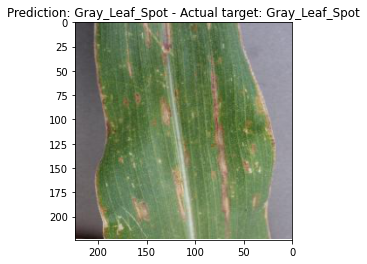

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
value_predictedl = []
test_target = []
with torch.no_grad():
  for inputs, target in  enumerate(eval_loader):
    inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed     #### valid_ds
    #print(inputs.shape)
    test_target.append(target)
    inputs = inputs[0].permute(1, 2, 0)
  #inputs = inputs.permute(1, 2, 0)
  # Save original Input
    originalInput = inputs
    for index, array in enumerate(inputs):
      inputs[index] = np.squeeze(array)
    inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
    inputs = inputs.to(device)
    target = target.to(device)
 
  # Generate prediction
    prediction= model(inputs)
    
    
  # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
    #value_predicted1= value_predicted

    y_test_pred =model(inputs) 
    #_, y_pred_tags = .argmax(prediction.cpu()) #torch.max(y_test_pred, dim = 1)
    
    value_predictedl.append(predicted_class)
    #value_predictedl = [a.tolist() for a in value_predictedl]
  
  
    # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

### Evaluate on a Test Data

In [ ]:
value_predictedl

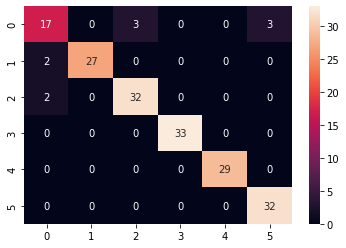

In [ ]:
# Confusion matrix

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

confusion_matrix_df = pd.DataFrame(confusion_matrix(test_target, value_predictedl))#.rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

# print(classification_report(y_test, y_pred_list))

In [ ]:
# Classification report
print(classification_report(test_target, value_predictedl))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77        23
           1       1.00      0.93      0.96        29
           2       0.91      0.94      0.93        34
           3       1.00      1.00      1.00        33
           4       1.00      1.00      1.00        29
           5       0.91      1.00      0.96        32

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1, 3, 224, 224])


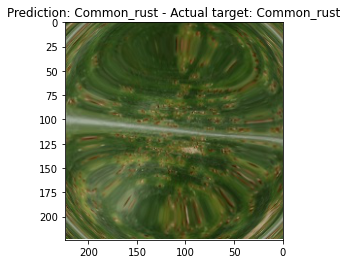

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed     #### valid_ds
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  #inputs = inputs.permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction, loss = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
  
  
    # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

### Save the Entire Model



In [ ]:
# # Saving the entire model
# torch.save(model, '/content/ViT_2nd_adjusted.pt')

# # export the trained model you have made here for inference to drive
# %cp /content/ViT_2nd_adjusted.pt /content/drive/MyDrive/MOG

### Use your Exported Model

In [ ]:
# MODEL_PATH = '/content/drive/MyDrive/MOG/ViT_model.pt'
# model_vit = torch.load(MODEL_PATH)
# model_vit.eval()

### Save as onnx

In [ ]:
import torch
import torchvision.models as models

#Create dummy input variables
dummy_input = torch.randn(1,3, 224, 224)
input_names = [ "actual_input" ]
output_names = [ "output" ] 

In [ ]:
#Model Path
model_path ="/content/drive/MyDrive/MOG/POWERPOINT/ViT_adjusted.onnx" 

#Saving the model as onnx file

torch.onnx.export(model, 
                  dummy_input,
                  model_path,
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

ValueError: ignored

In [ ]:
#create an inference session using the ‘onnxruntime’ python package and use it to make predictions

#import onnx runtime
import onnxruntime as onnxrt

#Model inferencing
onnx_session= onnxrt.InferenceSession(model_path)


#image to predict
img = "/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test/Blight/Corn_Blight (125).jpg"
onnx_inputs= {onnx_session.get_inputs()[0].name: to_numpy(img)}


onnx_output = onnx_session.run(None, onnx_inputs)
img_label = onnx_outputort_outs[0]

# Adjust Parameters

## Define the Model


In [ ]:


class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=6):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-large-patch32-384')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

In [ ]:
#Define the Model Parameters
#We train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5

EPOCHS = 3
BATCH_SIZE = 10
LEARNING_RATE = 2e-5

### Model Specifics
        * We will use the pretrained Vision Transformer feature extractor
        * an Adam Optimizer,
        * Cross Entropy Loss function.

In [ ]:
from transformers import ViTFeatureExtractor
import numpy as np
np.random.seed(0)
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-384') #google/vit-large-patch32-384
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda()

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


### Model Training

In [ ]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)  # (Change to two)

#The num_workers attribute tells the data loader instance how many sub-processes to use for data loading.
#By default, the num_workers value is set to zero, and a value of zero tells the loader to load the data inside the main process.

Number of train samples:  3000
Number of test samples:  660
Detected Classes are:  {'Blight': 0, 'Common_rust': 1, 'Gray_Leaf_Spot': 2, 'SMUT500': 3, 'healthy': 4, 'maizestreak_aug': 5}


In [ ]:
# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x, None)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(test_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)   #check split for un even sample
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

RuntimeError: ignored

### Evaluate on a Test Data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


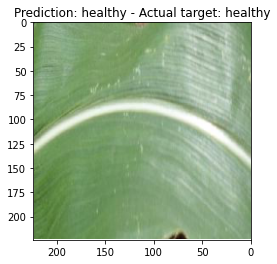

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
value_predictedl = []
test_target = []
with torch.no_grad():
  for inputs, target in  enumerate(eval_loader):
    inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed     #### valid_ds
    #print(inputs.shape)
    test_target.append(target)
    inputs = inputs[0].permute(1, 2, 0)
  #inputs = inputs.permute(1, 2, 0)
  # Save original Input
    originalInput = inputs
    for index, array in enumerate(inputs):
      inputs[index] = np.squeeze(array)
    inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
    inputs = inputs.to(device)
    target = target.to(device)
 
  # Generate prediction
    prediction, loss = model(inputs, target)
    
    
  # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
    value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
    value_predicted1= value_predicted

    y_test_pred =model(inputs, target) 
    #_, y_pred_tags = .argmax(prediction.cpu()) #torch.max(y_test_pred, dim = 1)
    
    value_predictedl.append(predicted_class)
    #value_predictedl = [a.tolist() for a in value_predictedl]
  
  
    # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()
  

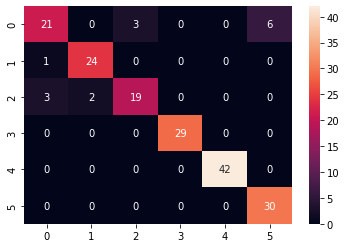

In [ ]:
#Confusion matrix

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

confusion_matrix_df = pd.DataFrame(confusion_matrix(test_target, value_predictedl))#.rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
#Clssification report
print(classification_report(test_target, value_predictedl))

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        30
           1       0.92      0.96      0.94        25
           2       0.86      0.79      0.83        24
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        42
           5       0.83      1.00      0.91        30

    accuracy                           0.92       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.92      0.92      0.91       180



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=2) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed     #### valid_ds
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  #inputs = inputs.permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction, loss = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
  
  
    # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

### Save the Entire Model



In [ ]:
# # Saving the entire model
# torch.save(model, '/content/ViT_model.pt')

# # export the trained model you have made here for inference to drive
#%cp /content/ViT_model.pt /content/drive/MyDrive/MOG

### Use your Exported Model

## Use the Vision Transformer Feature Extractor to Train the Model

* To train the model, we have written up a manual training script (can be found in the notebook). 
* Before each batch of images can be fed through the model, it is necessary to feed the images to the ViT feature extractor to obtain embeddings. 
* To do this, we first need to apply transformations to the batch to ensure it fits the appropriate constraints of the feature extractor. 
* The feature extractor requires a list of images and each image should have a shape of (num_channels, height, width)
* We do this by converting the single matrix that holds the batch of images into a list of matrices with each element of the list being the matrix of an individual image.

In [ ]:
# # Split the batch of images into a list of images & remove unecessary dimension
# x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
# # Remove unecessary dimensions (i.e. dimensions of size 1)
# for index, array in enumerate(x):
#    x[index] = np.squeeze(array)

# Linformer
      * Adam Optimizer
      * lr = 3e-5

In [ ]:
#Install the ViT PyTorch package and Linformer
%%capture
# !pip install vit-pytorch linformer

In [ ]:
# loading Libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Linformer
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

# import torch and related libraries
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR, ExponentialLR  
from torch.utils.data import DataLoader, Dataset

#sklearn to split the data

from sklearn.model_selection import train_test_split

In [ ]:
#definining batch size, epocs, learning rate and gamma for training 

batch_size = 12     #***
epochs = 10
lr = 3e-5
gamma = 0.7 #for learning rate scheduler  #***

In [ ]:
#Load data

train_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
test_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'
valid_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'


# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)



train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

valid_data = datasets.ImageFolder(valid_dir, transform=val_transforms)

test_data = datasets.ImageFolder(test_dir, transform=val_transforms)


print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(valid_data)}")
print(f"Test Data: {len(test_data)}")


train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

Train Data: 2999
Test Data: 660
Test Data: 180


In [ ]:
imagespath = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train/Blight'
img = 
for filename in sorted(os.listdir(imagespath)):
  if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".JPEG") or filename.endswith(".JPG"):
    label = imagespath.split('/')[-2]
label

'train'

In [ ]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12, #***
    heads=8,#***
    k=64  #2nd dimention of the p_bar matrix
)

In [ ]:
#Visual transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,  #***
    num_classes=6,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [ ]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.7981 - acc: 0.1817 - val_loss : 1.7633 - val_acc: 0.2318



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.6695 - acc: 0.2891 - val_loss : 1.5834 - val_acc: 0.3894



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.4423 - acc: 0.4161 - val_loss : 1.2825 - val_acc: 0.4833



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.3074 - acc: 0.4798 - val_loss : 1.2439 - val_acc: 0.5076



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.2138 - acc: 0.5132 - val_loss : 1.1523 - val_acc: 0.5591



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.1566 - acc: 0.5388 - val_loss : 1.1543 - val_acc: 0.5379



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.1070 - acc: 0.5595 - val_loss : 1.0933 - val_acc: 0.5667



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 8 - loss : 1.0585 - acc: 0.5806 - val_loss : 1.0361 - val_acc: 0.5909



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.0351 - acc: 0.5835 - val_loss : 1.0188 - val_acc: 0.6061



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.9922 - acc: 0.6105 - val_loss : 1.0163 - val_acc: 0.5879



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.9579 - acc: 0.6269 - val_loss : 0.9725 - val_acc: 0.6167



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.9505 - acc: 0.6306 - val_loss : 0.9364 - val_acc: 0.6212



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.9178 - acc: 0.6295 - val_loss : 0.9080 - val_acc: 0.6515



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.9116 - acc: 0.6422 - val_loss : 0.8838 - val_acc: 0.6530



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.8822 - acc: 0.6696 - val_loss : 0.8815 - val_acc: 0.6500



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.8580 - acc: 0.6699 - val_loss : 0.8688 - val_acc: 0.6727



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.8319 - acc: 0.6872 - val_loss : 0.8368 - val_acc: 0.6894



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.8391 - acc: 0.6862 - val_loss : 0.8354 - val_acc: 0.6636



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.8320 - acc: 0.6876 - val_loss : 0.8650 - val_acc: 0.6727



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.8088 - acc: 0.6859 - val_loss : 0.8398 - val_acc: 0.6803



# Linformer Optimization
        * SGD Optimizer

In [ ]:
#Load data

train_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
test_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'
valid_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'


# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)



train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

valid_data = datasets.ImageFolder(valid_dir, transform=val_transforms)

test_data = datasets.ImageFolder(test_dir, transform=val_transforms)


print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(valid_data)}")
print(f"Test Data: {len(test_data)}")


train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

Train Data: 2999
Test Data: 660
Test Data: 180


In [ ]:
# imagespath = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
# for filename in sorted(os.listdir(imagespath)):
#   if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".JPEG") or filename.endswith(".JPG"):
#     label = img.split('/')[-2]

In [ ]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler *********************

In [ ]:
efficient_transformer_dpth12 = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12, #***
    heads=8,#***
    k=64  #2nd dimention of the p_bar matrix
)

In [ ]:
#Visual transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_sgd = ViT(
    dim=128,
    image_size=224,
    patch_size=32,  #***
    num_classes=6,
    transformer=efficient_transformer_dpth12,
    channels=3,
).to(device)

In [ ]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.SGD(model.parameters(), lr=lr)  #shoter runtime, lower accuracy

# scheduler

scheduler = ExponentialLR(optimizer, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model_sgd(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model_sgd(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.0010 - acc: 0.1668 - val_loss : 1.9942 - val_acc: 0.1687



  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.0013 - acc: 0.1667 - val_loss : 1.9998 - val_acc: 0.1688



  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.0010 - acc: 0.1668 - val_loss : 2.0107 - val_acc: 0.1594



  0%|          | 0/47 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Linformer Optimization
        * Adagrad Optimizer

In [ ]:
#Load data

train_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
test_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'
valid_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'


# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)



train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

valid_data = datasets.ImageFolder(valid_dir, transform=val_transforms)

test_data = datasets.ImageFolder(test_dir, transform=val_transforms)


print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(valid_data)}")
print(f"Test Data: {len(test_data)}")


train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

NameError: ignored

In [ ]:
# imagespath = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
# for filename in sorted(os.listdir(imagespath)):
#   if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".JPEG") or filename.endswith(".JPG"):
#     label = img.split('/')[-2]

In [ ]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler *********************

In [ ]:
efficient_transformer_dpth12 = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12, #***
    heads=8,#***
    k=64  #2nd dimention of the p_bar matrix
)

In [ ]:
#Visual transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_sgd = ViT(
    dim=128,
    image_size=224,
    patch_size=32,  #***
    num_classes=6,
    transformer=efficient_transformer_dpth12,
    channels=3,
).to(device)

In [ ]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.AdamW(model.parameters(), lr=lr)  #shoter runtime, lower accuracy

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model_sgd(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model_sgd(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.8780 - acc: 0.1668 - val_loss : 1.8720 - val_acc: 0.1719



  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.8781 - acc: 0.1668 - val_loss : 1.8825 - val_acc: 0.1594



  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.8779 - acc: 0.1668 - val_loss : 1.8732 - val_acc: 0.1750



  0%|          | 0/47 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Linformer Optimization
        * Rprop Optimizer

In [ ]:
#Load data

train_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
test_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'
valid_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'


# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)



train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

valid_data = datasets.ImageFolder(valid_dir, transform=val_transforms)

test_data = datasets.ImageFolder(test_dir, transform=val_transforms)


print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(valid_data)}")
print(f"Test Data: {len(test_data)}")


train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

Train Data: 2999
Test Data: 660
Test Data: 180


In [ ]:
# imagespath = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
# for filename in sorted(os.listdir(imagespath)):
#   if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".JPEG") or filename.endswith(".JPG"):
#     label = img.split('/')[-2]

In [ ]:
batch_size = 64
epochs = 4
lr = 3e-5
gamma = 0.7 #for learning rate scheduler *********************

In [ ]:
efficient_transformer_dpth12 = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12, #***
    heads=8,#***
    k=64  #2nd dimention of the p_bar matrix
)

In [ ]:
#Visual transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_sgd = ViT(
    dim=128,
    image_size=224,
    patch_size=32,  #***
    num_classes=6,
    transformer=efficient_transformer_dpth12,
    channels=3,
).to(device)

In [ ]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.Rprop(model.parameters(), lr=lr)  #shoter runtime, lower accuracy

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model_sgd(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model_sgd(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.0312 - acc: 0.1664 - val_loss : 2.0204 - val_acc: 0.1688



  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.0315 - acc: 0.1668 - val_loss : 2.0162 - val_acc: 0.1687



  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.0313 - acc: 0.1668 - val_loss : 2.0402 - val_acc: 0.1688



  0%|          | 0/47 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.0313 - acc: 0.1667 - val_loss : 2.0328 - val_acc: 0.1625



# Linformer
      * Adam Optimizer
      * lr = 3e-7

In [ ]:
#Load data

train_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/train'
test_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'
valid_dir = '/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/valid'


# Torch transforms
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)



train_data = datasets.ImageFolder(train_dir, transform=train_transforms)

valid_data = datasets.ImageFolder(valid_dir, transform=val_transforms)

test_data = datasets.ImageFolder(test_dir, transform=val_transforms)


print(f"Train Data: {len(train_data)}")
print(f"Test Data: {len(valid_data)}")
print(f"Test Data: {len(test_data)}")


train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

Train Data: 2999
Test Data: 660
Test Data: 180


In [ ]:
batch_size = 64
epochs = 20
lr = 3e-3
gamma = 0.7 #for learning rate scheduler 

In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12, #***
    heads=8,#***
    k=64  #2nd dimention of the p_bar matrix
)

In [ ]:
#Visual transformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,  #***
    num_classes=6,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [ ]:
# loss function

criterion = nn.CrossEntropyLoss()

# optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.7994 - acc: 0.2157 - val_loss : 1.7721 - val_acc: 0.3045



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.6195 - acc: 0.3262 - val_loss : 1.5447 - val_acc: 0.3530



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.5563 - acc: 0.3551 - val_loss : 1.5550 - val_acc: 0.3242



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.5292 - acc: 0.3605 - val_loss : 1.4738 - val_acc: 0.3939



  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: ignored